In [2]:
import zipfile
import os

# Adjust the file name to match your uploaded file
# with zipfile.ZipFile('/content/double_mnist2.zip', 'r') as zip_ref:
#     zip_ref.extractall('double_mnist3')

with zipfile.ZipFile('/content/double_mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('double_mnist')

- In MultiLabel CNN model, we use a sigmoid activation function after the last linear layer, which is essential for multi-label classification

## Multi-Label vs. Multi-Class Classification:

- In multi-label classification, each sample can belong to multiple classes simultaneously. For example, in digit sequence classification, each position (up to max_digits) in the sequence may independently represent any digit from 0 to 9.
- In multi-class classification (with softmax activation), we assume only one label is correct per instance. Softmax normalizes outputs so that the sum of probabilities across all classes is 1, effectively picking one class as the output.

### Why Sigmoid?

- The sigmoid function compresses each output independently to a range between 0 and 1, allowing each digit prediction to act independently for each position.
- This is essential in multi-label setups where the model needs to predict multiple classes for each instance (digits in a sequence), not just one.
- Unlike softmax, sigmoid treats each position’s prediction separately, enabling the model to make independent binary decisions for each class.

**If we use softmax here, it would force a competition between classes, giving only one digit as the output per position and inhibiting the model's ability to assign multiple classes.**

.

LR=0.01, Dropout=0.4, ConvLayers=2, Optimizer=Adam - Train Loss: 0.6716369921483364, Val Loss: 0.6612719481295728
LR=0.01, Dropout=0.4, ConvLayers=3, Optimizer=Adam - Train Loss: 0.6764713828333744, Val Loss: 0.6654213673256814
LR=0.01, Dropout=0.7, ConvLayers=2, Optimizer=Adam - Train Loss: 0.8203133452059653, Val Loss: 1.1247409810411169
LR=0.01, Dropout=0.7, ConvLayers=3, Optimizer=Adam - Train Loss: 0.6848949327081593, Val Loss: 0.6654213673256814
LR=0.001, Dropout=0.4, ConvLayers=2, Optimizer=Adam - Train Loss: 0.6702258237424841, Val Loss: 0.6553211985750401
LR=0.001, Dropout=0.4, ConvLayers=3, Optimizer=Adam - Train Loss: 0.6763852517011807, Val Loss: 0.6654213673256814
LR=0.001, Dropout=0.7, ConvLayers=2, Optimizer=Adam - Train Loss: 0.681721054055364, Val Loss: 0.6559095065644447
LR=0.001, Dropout=0.7, ConvLayers=3, Optimizer=Adam - Train Loss: 0.6817746350002772, Val Loss: 0.6553569943346875


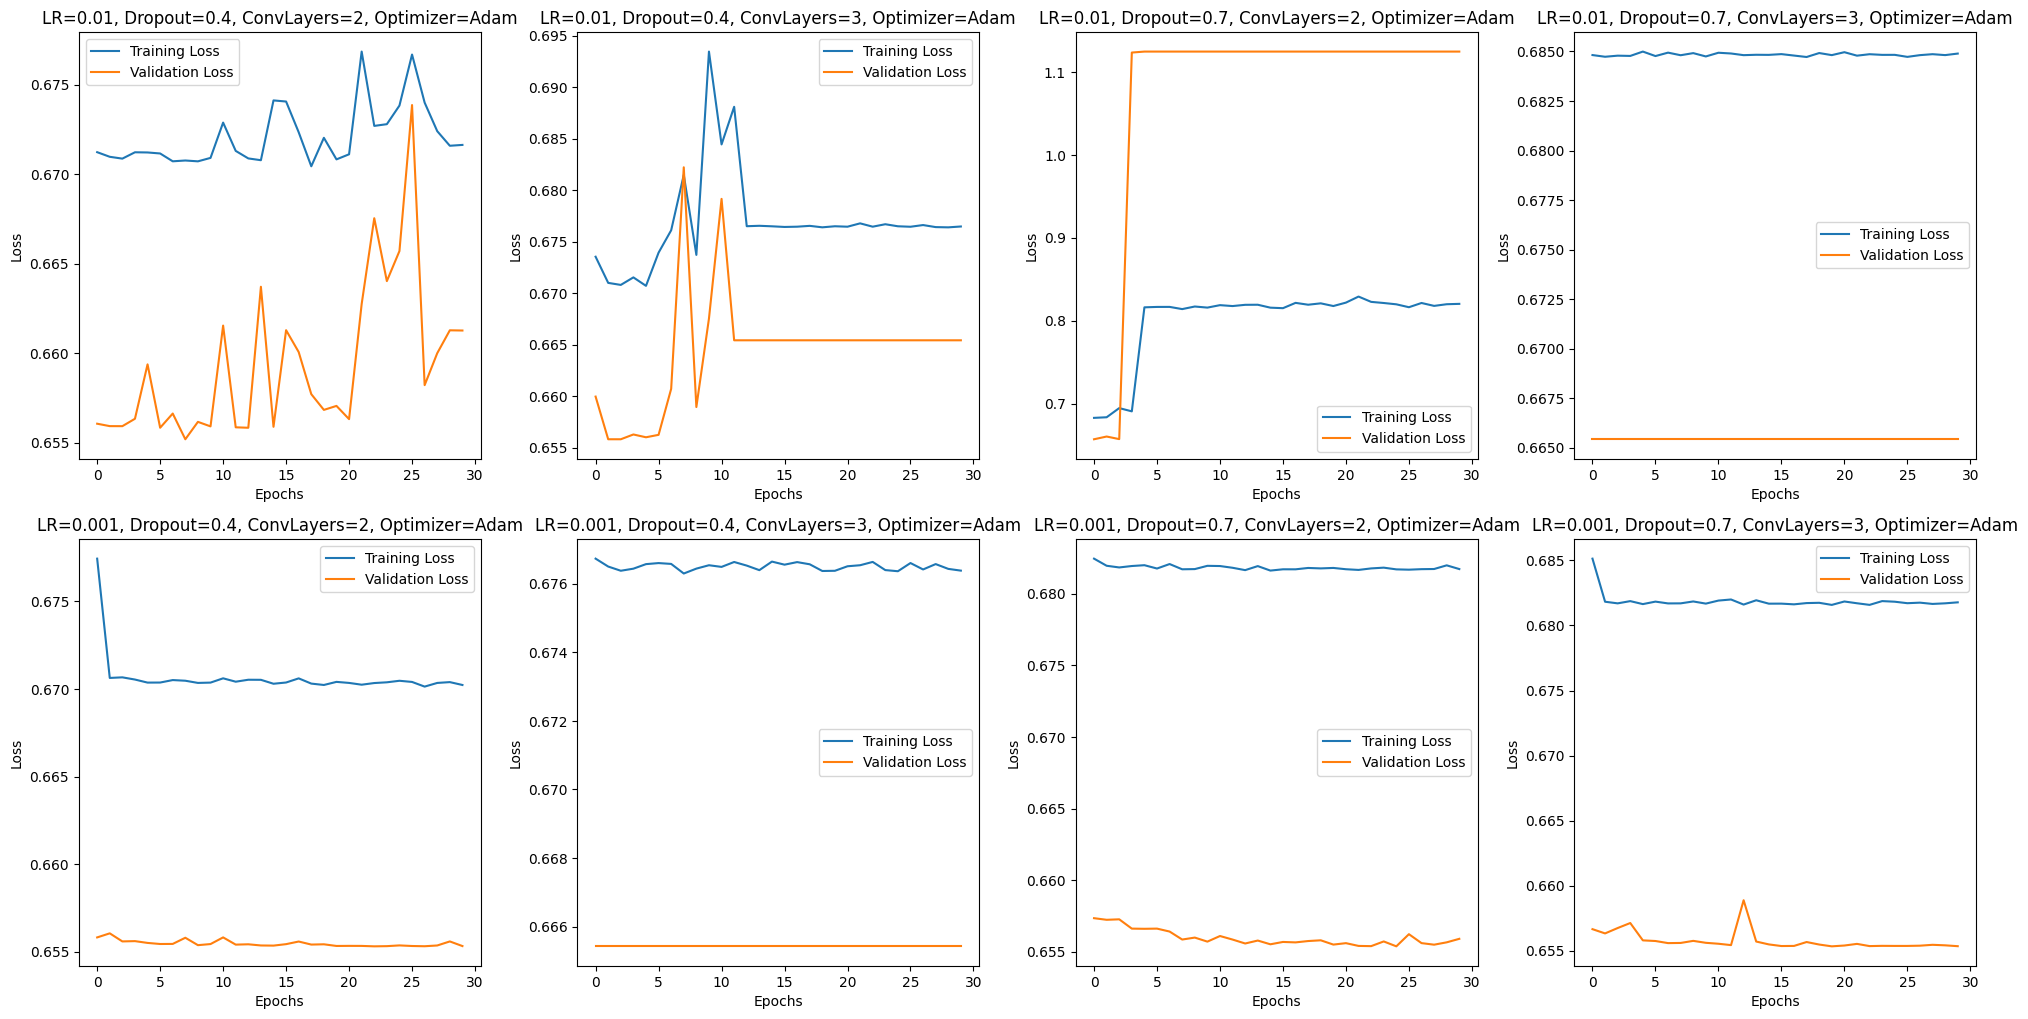

In [3]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data Loading and Preprocessing
def load_mnist_data(data_path, max_digits=5):
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_path, split)
        for label_name in os.listdir(split_path):
            label = [int(digit) for digit in label_name]

            # Padding
            padded_label = label + [0] * (max_digits - len(label))
            one_hot_label = np.zeros((10, max_digits), dtype=np.float32)
            for idx, digit in enumerate(padded_label):
                one_hot_label[digit, idx] = 1.0
            image_folder = os.path.join(split_path, label_name)
            for img_file in os.listdir(image_folder):
                img_path = os.path.join(image_folder, img_file)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (28, 28))

                if split == 'train':
                    train_data.append(image)
                    train_labels.append(one_hot_label)
                elif split == 'val':
                    val_data.append(image)
                    val_labels.append(one_hot_label)
                elif split == 'test':
                    test_data.append(image)
                    test_labels.append(one_hot_label)

    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

# Custom Dataset Class
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize to [0, 1]
        label = torch.tensor(label, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, label


data_path = '/content/double_mnist/double_mnist'
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = load_mnist_data(data_path)

train_dataset = MultiMNISTDataset(train_data, train_labels)
val_dataset = MultiMNISTDataset(val_data, val_labels)
test_dataset = MultiMNISTDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Multi-Label CNN Model
class MultiLabelCNN(nn.Module):
    def __init__(self, num_conv_layers=3, dropout_rate=0.5, max_digits=5, num_classes=10):
        super(MultiLabelCNN, self).__init__()

        self.num_conv_layers = num_conv_layers
        self.dropout_rate = dropout_rate
        self.max_digits = max_digits
        self.num_classes = num_classes

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)

        # Fully Connected Layer
        if self.num_conv_layers == 2:
            self.fc = nn.Linear(64 * 7 * 7, num_classes * max_digits)
        else:
            self.fc = nn.Linear(128 * 3 * 3, num_classes * max_digits)

        # Dropout
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        if self.num_conv_layers > 1:
            x = F.relu(self.conv2(x))
            x = self.pool(x)
        if self.num_conv_layers > 2:
            x = F.relu(self.conv3(x))
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc(x)))
        return torch.sigmoid(x).view(-1, self.num_classes, self.max_digits)

# Hyperparameter Tuning
# configs
learning_rates = [0.01, 0.001]
dropout_rates = [0.4, 0.7]
num_conv_layers = [2, 3]
optimizers = ['Adam']
epochs = 30

# store losses for each combination
loss_records = {}

# Loop through hyperparameter combinations
for lr in learning_rates:
    for dropout in dropout_rates:
        for conv_layers in num_conv_layers:
            for opt in optimizers:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model = MultiLabelCNN(num_conv_layers=conv_layers, dropout_rate=dropout).to(device)

                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr) if opt == 'Adam' else optim.SGD(model.parameters(), lr=lr)

                train_losses, val_losses = [], []

                for epoch in range(epochs):
                    # Train the model
                    model.train()
                    epoch_train_loss = 0.0
                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        epoch_train_loss += loss.item()
                    avg_train_loss = epoch_train_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # Validate the model
                    model.eval()
                    epoch_val_loss = 0.0
                    with torch.no_grad():
                        for images, labels in val_loader:
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                            epoch_val_loss += loss.item()
                    avg_val_loss = epoch_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)

                key = f"LR={lr}, Dropout={dropout}, ConvLayers={conv_layers}, Optimizer={opt}"
                loss_records[key] = {'train_loss': train_losses, 'val_loss': val_losses}

                print(f"{key} - Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

# Plot results
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

for i, (key, losses) in enumerate(loss_records.items()):
    axes[i].plot(losses['train_loss'], label='Training Loss')
    axes[i].plot(losses['val_loss'], label='Validation Loss')
    axes[i].set_title(f"{key}")
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

best_model_key = min(loss_records, key=lambda x: loss_records[x]['val_loss'][-1])

train_losses = loss_records[best_model_key]['train_loss']
val_losses = loss_records[best_model_key]['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss for Best Model ({best_model_key})")
plt.legend()
plt.show()


In [ ]:
import torch

def exact_match_accuracy(predictions, labels):
    # Check if predictions and labels match exactly for each sample
    exact_matches = (predictions.argmax(dim=1) == labels.argmax(dim=1)).all(dim=1)
    return exact_matches.float().mean().item()

def hamming_accuracy(predictions, labels):
    # Compute accuracy for each position independently
    per_position_accuracy = (predictions.argmax(dim=1) == labels.argmax(dim=1)).float()
    return per_position_accuracy.mean().item()

def evaluate_model(model, dataloader, device):
    model.eval()
    exact_match_acc, hamming_acc = 0.0, 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            exact_match_acc += exact_match_accuracy(outputs, labels) * len(images)
            hamming_acc += hamming_accuracy(outputs, labels) * len(images)
            total_samples += len(images)

    # Average over all samples
    exact_match_acc /= total_samples
    hamming_acc /= total_samples

    return exact_match_acc, hamming_acc

# Assuming train_loader, val_loader, and test_loader are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(num_conv_layers=best_model_key['conv_layers'], dropout_rate=best_model_key['dropout_rate']).to(device)

# Evaluate on each dataset
train_exact, train_hamming = evaluate_model(model, train_loader, device)
val_exact, val_hamming = evaluate_model(model, val_loader, device)
test_exact, test_hamming = evaluate_model(model, test_loader, device)

# Report results
print(f"Best Model Configuration: {best_model_key}")
print("Train Set: Exact Match Accuracy = {:.2f}%, Hamming Accuracy = {:.2f}%".format(train_exact * 100, train_hamming * 100))
print("Validation Set: Exact Match Accuracy = {:.2f}%, Hamming Accuracy = {:.2f}%".format(val_exact * 100, val_hamming * 100))
print("Test Set: Exact Match Accuracy = {:.2f}%, Hamming Accuracy = {:.2f}%".format(test_exact * 100, test_hamming * 100))



## Best Model :
LR=0.001, Dropout=0.7, ConvLayers=3, Optimizer=Adam

Train Loss: 0.6817746350002772, Val Loss: 0.6553569943346875
### Performance
- Model saved as best_model.pth  
- Train Exact Match Accuracy: 0.5372  
- Train Hamming Accuracy: 0.9741  
- Validation Exact Match Accuracy: 0.5187  
- Validation Hamming Accuracy: 0.9446  
- Test Exact Match Accuracy: 0.5635  
- Test Hamming Accuracy: 0.9172  
